# Project 4: Identify fraud from Enron email
***

## 1. Introduction
The Enron Corporation was an American energy company based in Houston, Texas, which filed for bankruptcy in December 2001 after years of intentional financial mismanagement carried out by a group of its executives, who hided multimillion-dollar debts from both auditors and directors' board, leading the company, as well as it employees and shareholders, to the ruin (Wikipedia, 2020, a).

During the subsequent investigation, a database of emails sent by employees of the company was created by the Federal Energy Regulatory Commission using data from the Enron servers, known as the Enron corpus. A copy of this corpus was later purchased by a private person and publicly released, representing one of the largest collections of real emails available, which has since then been used for studies in different disciplines, such as social networking or natural language processing (Wikipedia, 2020, b).

The goal of this project is to use the data in this corpus, together with additional financial information available, to identify possible persons of interest (POIs) in the Enron fraud case. The idea is to make use of the machine learning techniques acquired during this lesson of the course (Intro to Machine Learning), in order to help us unveil hidden patterns in the data which might help us identify the people involved in the fraud case.

## 2. Dataset: exploration and outliers

In [1]:
# Load required libraries and functions
import sys
import pickle
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

In [2]:
# Define features to be loaded, separated in 3 categories: payments, stock value and email features
payments_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 
                     'other', 'expenses', 'director_fees', 'total_payments']
stock_value_features =  ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                  'shared_receipt_with_poi']

features_list = ['poi'] + payments_features + stock_value_features + email_features

In [3]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
print("There are a total of %i data points in the dataset." % (len(data_dict)))

There are a total of 146 data points in the dataset.


The original dataset contained in the *final_project_dataset.pkl* file contains 146 rows of information, both financial and email. However, after having a close look at the dictionary keys I found two suspicious values: *TOTAL* (already identified during the course) and *THE TRAVEL AGENCY IN THE PARK*. I considered these points to be outliers as they do not correspond to any employees. Therefore, I removed them from the final dataset.

In [5]:
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

Additionally, there is one data point containing only NaNs, which corresponds to the employee *LOCKHART EUGENE E*. I removed this point from the dataset as well, as it is not providing any information in terms of features.

In [6]:
data_dict.pop('LOCKHART EUGENE E', 0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

In [7]:
# Extract features and labels from dataset for local testing (keep NaNs for first feature analysis)
data = featureFormat(data_dict, features_list, remove_NaN=False, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)

# Add data to DataFrame and add a column with the name of the corresponding employee
data_df = pd.DataFrame(data, columns=features_list)
data_df = data_df.assign(name=sorted(data_dict.keys()))

In [8]:
# Get total number of people, POIs and non-POIs remaining in the dataset
num_people = len(data_df['poi'])
num_pois = sum(data_df['poi'])
num_non_pois = num_people - num_pois

print("Number of people remaining in the dataset: %i" % (num_people))
print("Number of POIs: %i" % (num_pois))
print("Number of non-POIs: %i" % (num_non_pois))

Number of people remaining in the dataset: 143
Number of POIs: 18
Number of non-POIs: 125


After removing the two outliers, there are 143 people in the database, 18 of which are POIs. The relatively small proportion of POIs in the dataset might impact the prediction capabilities of the algorithm, therefore, extra care is needed when handling the data and when splitting the data into training and testing sets.

## 3. Features selection

I decided to do the feature selection by hand &ndash; making use of the Pandas Dataframes capabilities &ndash; instead of using an algorithm to provide me the most meaningful features. The reason for this is that these kind of methodologies &ndash; such as ANOVA &ndash; tend to be quite sensitive to the number and type of variables that are given as input and, given the relatively small number of features in this database, I considered it more advantageous to do an intelligent analysis of the data features before creating the classifier than to tune an additional algorithm to do it for me.

There are a total of 20 features available in the original dataset (not including the label 'poi'), which I split into three categories which can be analyzed independently:
- Payment-related features: salary, bonus, long_term_incentive, deferred_income, deferral_payments, loan_advances, other, expenses, director_fees, total_payments
- Stock-related features: exercised_stock_options, restricted_stock, restricted_stock_deferred, total_stock_value
- Email-related features: to_messages, from_poi_to_this_person, from_messages, from_this_person_to_poi, shared_receipt_with_poi

At first I loaded all features together to have an overall view of the data. However, a quick look at the amount of information available for each feature showed me that there are several features where more than 50% of the points are NaNs: deferral_payments, loan_advances, deferred_income, long_term_incentive, director_fees and restricted_stock_deferred. I removed these features from the dataset.

In [9]:
# Compute the percentage of NaNs contained in each feature
(data_df.isna().sum()/ num_people) * 100

poi                           0.000000
salary                       34.265734
bonus                        43.356643
long_term_incentive          54.545455
deferred_income              66.433566
deferral_payments            73.426573
loan_advances                97.902098
other                        36.363636
expenses                     34.265734
director_fees                88.811189
total_payments               13.986014
exercised_stock_options      29.370629
restricted_stock             23.776224
restricted_stock_deferred    88.111888
total_stock_value            12.587413
to_messages                  39.860140
from_poi_to_this_person      39.860140
from_messages                39.860140
from_this_person_to_poi      39.860140
shared_receipt_with_poi      39.860140
name                          0.000000
dtype: float64

### Payments features
I first analyzed the features related to payments by loading the data into a new dataframe (now changing the NaNs to zeros) and using a seaborn pairplot.

In [10]:
payments_features = ['salary', 'bonus', 'other', 'expenses', 'total_payments']
features_list = ['poi'] + payments_features

# Extract features and labels from dataset (changing NaNs to zeros) and 
payments_data = featureFormat(data_dict, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False,
                              sort_keys=True)
payments_df = pd.DataFrame(payments_data, columns=features_list)
payments_df = payments_df.assign(name=sorted(data_dict.keys()))

In [11]:
import seaborn as sns
sns.set()

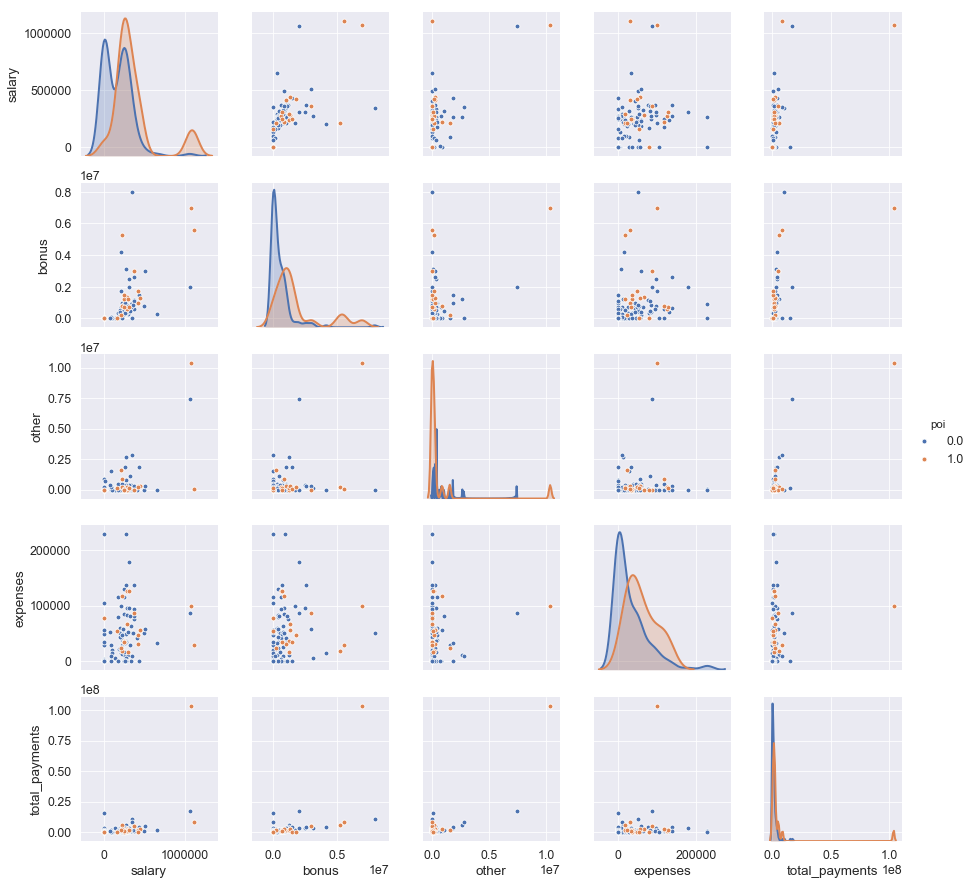

In [12]:
sns.set_context("paper", font_scale=1.4, rc={"lines.linewidth": 2.0})
sns.pairplot(payments_df, hue='poi', vars=payments_features)

By looking at the plots, I decided to keep the features **salary**, **bonus** and **expenses**, as these are the most homogeneously distributed and they do not seem to be highly correlated to each other. It is easy to see that the features other and total payments present a few points with values significantly higher than the rest, which might affect the prediction. Another way to look at it would be to look at the histograms and try to figure out from which variables could we get a prediction via statistical testing.

Since these variables are given in absolute terms, I decided to create new features in the dataset to compute the ratio of each of these features with respect to the total payments received. The idea behind is that, for instance, we might have individuals with unusually large bonuses influencing the trends in the data, but then realize that the amount of bonus is in reality proportionate to the total amount of payments they received &ndash; i.e. they received a large bonus because their overall income was larger than that of other employees. In order to compute these variables, I used a helper function included in the file *helper_functions.py*.

In [13]:
from helper_functions import AddRatio2Data

In [14]:
# Store to my_dataset for easy export
my_dataset = data_dict

In [15]:
my_dataset = AddRatio2Data(my_dataset, 'salary', 'total_payments', 'ratio_salary2total')
my_dataset = AddRatio2Data(my_dataset, 'bonus', 'total_payments', 'ratio_bonus2total')
my_dataset = AddRatio2Data(my_dataset, 'expenses', 'total_payments', 'ratio_expenses2total')

In a later step I tested whether to use absolute or relative variables.

### Email features

For the email features I followed the same process as above.

In [16]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                  'shared_receipt_with_poi']
features_list = ['poi'] + email_features

# Extract features and labels from dataset (changing NaNs to zeros) and 
email_data = featureFormat(data_dict, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False,
                           sort_keys=True)
email_df = pd.DataFrame(email_data, columns=features_list)
email_df = email_df.assign(name=sorted(data_dict.keys()))

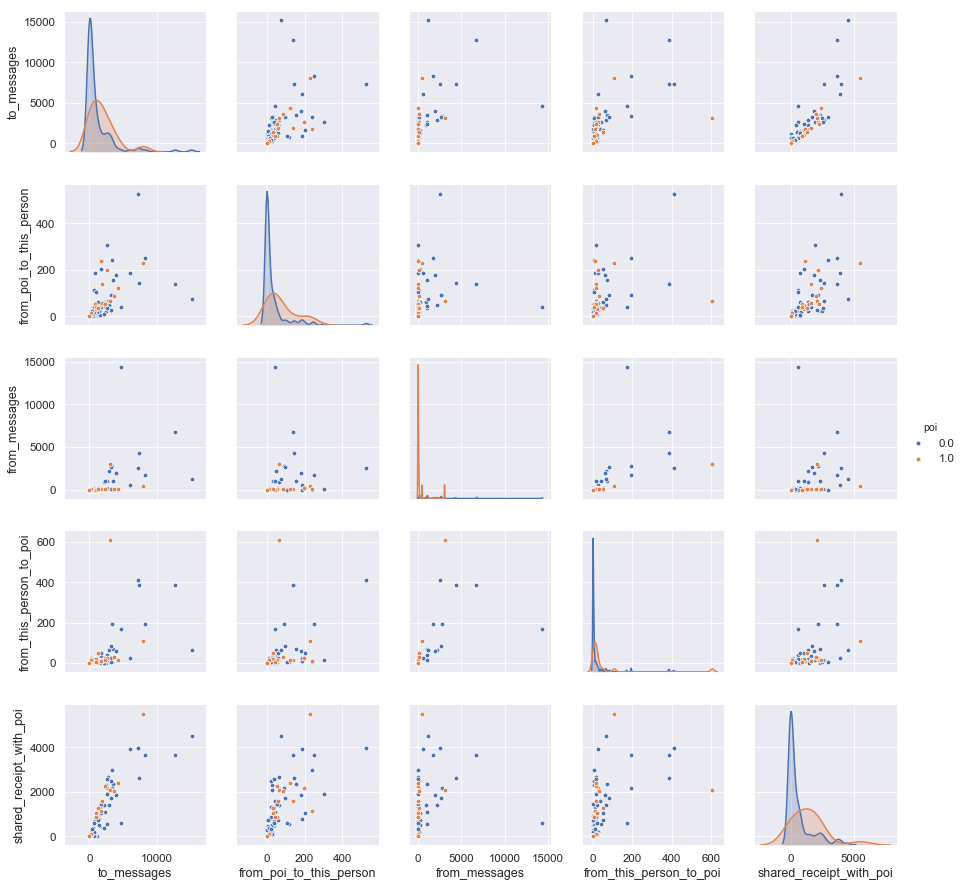

In [17]:
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.5})
sns.pairplot(email_df, hue='poi', vars=email_features)

In this case, there seems to be three variables which present good data (i.e. homogeneous and not highly correlated to each other): to_messages, from_poi_to_this_person and shared_receipt_with_poi. The other two variables present a relatively high level of scatter and some outlying points which might affect the prediction. From a logical point of view, it seems rather unlikely that we can predict whether a person is a POI or not from the total number of emails received. For this reason, I decided to keep only the features **from_poi_to_this_person** and **shared_receipt_with_poi**.

Similarly to the payments, from these features I generated two new variables showing the ratio of emails received from or shared with a POI with respect to the total number of emails received. The reason is to have variables that can tell not how many emails a person has received from POIs, but to indicate the proportion that these emails represent in that person's inbox.

In [18]:
# Add new features for percentage of messages received from and shared with poi
my_dataset = AddRatio2Data(my_dataset, 'from_poi_to_this_person', 'to_messages', 'ratio_received_from_poi')
my_dataset = AddRatio2Data(my_dataset, 'shared_receipt_with_poi', 'to_messages', 'ratio_shared_with_poi')

### Stock value features
I followed the same process for the stock value features.

In [19]:
stock_value_features =  ['exercised_stock_options', 'restricted_stock', 'total_stock_value']
features_list = ['poi'] + stock_value_features

# Extract features and labels from dataset (changing NaNs to zeros) and 
stock_data = featureFormat(data_dict, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False,
                           sort_keys=True)
stock_df = pd.DataFrame(stock_data, columns=features_list)
stock_df = stock_df.assign(name=sorted(data_dict.keys()))

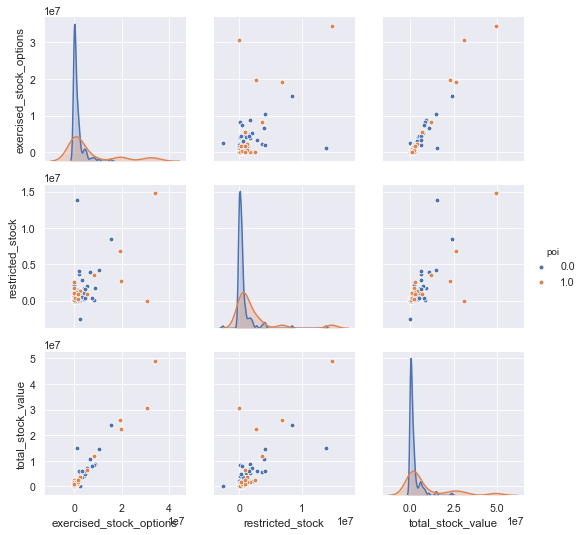

In [20]:
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.5})
sns.pairplot(stock_df, hue='poi', vars=stock_value_features)

The selection in this case seems a bit more difficult, as all variables present good-quality data. Nevertheless, it is easy to identify a certain correlation between the feature total_stock_value and the other two variables &ndash; this makes sense, since the total value of the stock is nothing more than a linear combination of the other two features. For this reason, I restricted the selection to two alternatives:
- exercised_stock_options and restricted_stock
- total_stock_value

To help me take the decision, I used a function to test a classifier on two different groups of features and provide me the evaluation metrics of both, in order to choose the most suitable one. For this, I made use of a Naive Bayes classifier, which is simple, robust and does not need to be tuned to provide solid results.

In [21]:
# Create classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [22]:
# Obtain the first set of data (using exercised_stock_options and restricted_stock)
features_list = ['poi', 'salary', 'bonus', 'expenses', 'from_poi_to_this_person', 'shared_receipt_with_poi',
                'exercised_stock_options', 'restricted_stock']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)

In [23]:
from helper_functions import TestClassifier
# Test classifier on data
print(TestClassifier(clf, data))

Elapsed time = 1.65 seconds.
{'f1': 0.33598, 'recall': 0.307, 'f2': 0.31797, 'precision': 0.371, 'accuracy': 0.8382}


In [24]:
# Obtain the second set of data (using total_stock_value)
features_list = ['poi', 'salary', 'bonus', 'expenses', 'from_poi_to_this_person', 'shared_receipt_with_poi',
                'total_stock_value']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)

# Test classifier on data
print(TestClassifier(clf, data))

Elapsed time = 1.81 seconds.
{'f1': 0.36871, 'recall': 0.3405, 'f2': 0.35125, 'precision': 0.40201, 'accuracy': 0.84453}


As it can be seen, all the metrics computed show an improvement of the classifier when working only with the feature **total_stock_value**, so I kept this one for the final dataset.

### Absolute vs. relative features

As described above, I generated new features for payments and emails data by computing the ratio versus the total value. In order to test the influence of these features in the prediction and help me decide whether to work with absolute or with relative features, I followed the same methodology as above and tested both possibilities with a Naive Bayes classifier.

First, I tested the classifier using both payments and emails relative features, and then I ran tests using only either the payments or the emails features as relative variables. 

In [25]:
# Generate a dataset with all the relative variables
features_list = ['poi', 'total_stock_value',
                 'ratio_salary2total', 'ratio_bonus2total', 'ratio_expenses2total',
                 'ratio_received_from_poi', 'ratio_shared_with_poi']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)
# Test classifier on data
print(TestClassifier(clf, data))

Elapsed time = 1.75 seconds.
{'f1': 0.38359, 'recall': 0.2805, 'f2': 0.31429, 'precision': 0.60649, 'accuracy': 0.8798}


In [26]:
# Generate a dataset with payments relative features
features_list = ['poi', 'total_stock_value',
                 'ratio_salary2total', 'ratio_bonus2total', 'ratio_expenses2total',
                 'from_poi_to_this_person', 'shared_receipt_with_poi']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)
# Test classifier on data
print(TestClassifier(clf, data))

Elapsed time = 1.66 seconds.
{'f1': 0.30396, 'recall': 0.2475, 'f2': 0.26736, 'precision': 0.39379, 'accuracy': 0.84887}


In [27]:
# Generate a dataset with emails relative features
features_list = ['poi', 'total_stock_value', 'salary', 'bonus', 'expenses',
                 'ratio_received_from_poi', 'ratio_shared_with_poi']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)
# Test classifier on data
print(TestClassifier(clf, data))

Elapsed time = 1.19 seconds.
{'f1': 0.36456, 'recall': 0.3045, 'f2': 0.32598, 'precision': 0.45414, 'accuracy': 0.85847}


The following table summarizes the results obtained through the different combinations of relative and absolute features:

| Payments features | Stock features | Email features | Precision | Recall | F1 | F2 | Accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Absolute | Absolute | Absolute | 0.40201 | 0.34050 | 0.36871 | 0.35125 | 0.84453 |
| Relative | Absolute | Relative | 0.60649 | 0.28050 | 0.38359 | 0.31429 | 0.87980 |
| Relative | Absolute | Absolute | 0.39379 | 0.24750 | 0.30396 | 0.26736 | 0.84887 |
| Absolute | Absolute | Relative | 0.45414 | 0.30450 | 0.36456 | 0.32598 | 0.85847 |

Where precision and recall are defined as follows (Wikipedia, 2020, c):

\begin{align}
Precision = \frac{True Positives}{True Positives + False Positives} \\ \\
Recall = \frac{True Positives}{True Positives + False Negatives}
\end{align}

The F1 metric is the harmonic mean of the precision and recall and the F2 score is a weighted average of the same metrics, but giving more weight to the recall.

From these mathematical expressions, we can infer that the precision indicates the percentage of positively-predicted cases that are truly positive &ndash; i.e. the percentage of POIs predicted by the algorithm that are really persons of interest in the Enron dataset. The recall, on the other hand, gives the percentage of relevant cases that are correctly detected by the algorithm &ndash; in this case, how many POIs is the algorithm able to detect.

The choice of whether to use the relative or the absolute features for the email variables depends on the final goal of the classifier. Given that the objective of this exercise is to identify Enron Employees *who may have committed* fraud (according to the Udacity course website), I consider that the algorithm should aim at maximizing the number of true POIs detected, even if this means increasing the number of false positives predicted. For this reason, I decided to use absolute features for all variables, as this seemed to maximize the value of the recall.

To summarize, after running through the feature selection process, I chose the following variables for the final analysis:
- Payments features: **salary, bonus, expenses**
- Emails features: **from_poi_to_this_person, shared_receipt_with_poi**
- Stock value features: **total_stock_value**

These features, used in a GaussianNB classifier, provided the following results:

| Algorithm | Tuned | Feature scaling | Precision | Recall | F1 | F2 | Accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- |
| GaussianNB | No | No | 0.40201 | 0.34050 | 0.36871 | 0.35125 | 0.84293 |

## 4. Classification algorithm
In the feature selection process I used a Naive Bayes classifier to test the performance of different combinations of features and I converged to a estimator offering precision and recall values larger than 0.3. Even if this performance is already matching the target defined for this exercise, I decided to test the following classifiers and compare them to the GaussianNB in order to pick the most suitable one for this dataset:
- K-neighbors: sklearn.neighbors.KNeighborsClassifier
- Support Vector Machine (SVM from now on): sklearn.svm.SVC
- Decision Tree: sklearn.tree.DecisionTreeClassifier

The reason to choose these classifiers is that each one of them represents a different philosophy of machine learning classification. 

Parallel to the testing of the different classification methods, I performed the tuning of each algorithm. This process consists in adjusting of the hyper-parameters of the classifier in order to optimize its performance for a given dataset. Hyper-parameters are parameters that are not directly learned within estimators (Scikit learn, 2020, a) &ndash; in contrast to parameters, which are usually learned from the data &ndash; and whose value is used to control the learning process. 

An example of hyper-parameter to be tuned could be the kernel type in the SVM classifiers (SVC from now on), which defines the type of decision boundary that the SVC will produce. It is important to define this variable correctly, since otherwise we could be using a separator line not suitable for our data &ndash; e.g. using a linear boundary for a dataset where the classes are distributed as concentric circles. From now on, however, I will talk of *parameters* instead of *hyper-parameters* for simplicity.

For the algorithm tuning, I wrote a function which tests the classifier on all the different combination of parameters and performs the evaluation using the StratifiedShuffleSplit cross validation. The reason for this is that the limited size of the database &ndash; with a very low percentage of POIs &ndash; would produce biased results if only one split of the data in test and training sets were used. The function TuneClassifier is included in the *helper_functions.py* file and returns a dataframe with the evaluation results of each parameter combination. Having the results of the parameter tuning in a dataframe allowed me to have more control on the process, when comparing to algorithms such as GridSearchCV, being able to compare different metrics and selecting the combination of most suitable combination of parameters for my purpose.

### KNeighborsClassifier
Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point (Scikit learn, 2020, b).

For the tuning of the KNeighborsClassifier I selected the following parameters:
- n_neighbors: number of neighbor points to be used by the classifier to predict the class of the query, i.e. **_k_**
- weights: weight function to be used in the prediction &ndash; e.g. if *distance* used, data points closer to the query are given more weight in the prediction
- algorithm: method used to compute the nearest neighbors
- metric: metric used for the distance computation

In [28]:
# Import functions
from helper_functions import TuneClassifier
from sklearn.neighbors import KNeighborsClassifier

In [29]:
# Prepare input data
features_list = ['poi', 'salary', 'bonus', 'expenses', 'from_poi_to_this_person', 'shared_receipt_with_poi',
                'total_stock_value']
data = featureFormat(my_dataset, features_list, remove_NaN=True, remove_all_zeroes=False, remove_any_zeroes=False, 
                     sort_keys=True)

In [30]:
# Define the classifier and parameters to be tuned
parameters_knn = {'n_neighbors':[1,2,3,4],
                  'weights':('uniform', 'distance'),
                  'algorithm':('ball_tree', 'kd_tree', 'auto'),
                  'metric':('euclidean','minkowski')}
clf_knn = KNeighborsClassifier()

In [31]:
# Tune classifier
results_knn_df = TuneClassifier(clf_knn, parameters_knn, data)

Testing a total of 48 parameter combinations.
Classifier tuning finished.


In [32]:
# Print the evaluation of the parameter combinations providing precision and recall > 0.3 sorting the results by F1 and F1
results_knn_df[(results_knn_df['precision']>0.3) & (results_knn_df['recall']>0.3)].sort_values(
               by=['f1', 'f2'], ascending=False)[['precision','recall','f1','f2','accuracy','parameters']]

,precision,recall,f1,f2,accuracy,parameters
5,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."
13,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."
21,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."
29,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."
37,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."
45,0.45547,0.312,0.37033,0.33298,0.85853,"{u'n_neighbors': 3, u'n_jobs': None, u'algorit..."


The results show that there are several combinations of parameters providing the same performance, which indicates that there are some parameters which do not influence the results. These are the algorithm and the metric parameters, where the choices given seem to vary the results.

For the final comparison I simply chose the combination where the algorithm and the metric parameters are equal to their default values.

In [33]:
# Best parameter settings
best_params_knn = results_knn_df['parameters'][45]
print(best_params_knn)

{'n_neighbors': 3, 'n_jobs': None, 'algorithm': 'auto', 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'weights': 'distance', 'leaf_size': 30}


In [34]:
# Print out the evaluation metrics for the optimized parameter set
results_knn_df[['precision','recall','f1','f2','accuracy']].loc[45]

precision    0.45547
recall       0.31200
f1           0.37033
f2           0.33298
accuracy     0.85853
Name: 45, dtype: float64

### SVC
A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier (Scikit learn, 2020, c).

For the Support Vector Classifier I chose the following features:
- C: regularization parameter, algorithms with lower C values give more importance to maximizing the minimum margin of the hyperplane, whereas those with larger C values will try to maximize the number of instances correctly classified
- kernel: specifies the type of boundary between classes
- degree: defines the degree of the polynomial in the kernel type *poly*
- gamma: kernel coefficient used for *rbf*, *poly* and *sigmoid* types

Additionally, I increased the kernel cache size (cache_size parameter) in order to decrease the running time and set the class_weight parameter to *balanced* so as to adjust the relevance given to the different classes in the data, as recommended in the scikit learn documentation for unbalanced problems such as this one (with quite a low percentage of POIs).

It is also worth mentioning that I have scaled the features before running the classifier (input option *feature_scaling*). Given that the SVM algorithms are based on distance computations, it is recommended to scale the input data in order to avoid biases in the results due to the different orders of magnitude between features. For this, I used the *MinMaxScaler()* function available in sklearn, which scales each feature based on its minimum and maximum values.

In [36]:
# Define the classifier and parameters to be tuned
from sklearn.svm import SVC
parameters_svc = {'C':[0.1,0.5,1.,2.,5.],
                  'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
                  'degree':[2,3,4],
                  'gamma':('auto', 'scale'),
                  'class_weight':['balanced'],
                  'cache_size':[1000]}
clf_svc = SVC()

In [37]:
# Tune classifier
results_svc_df = TuneClassifier(clf_svc, parameters_svc, data, feature_scaling=True)

Feature scaling is active.
Testing a total of 120 parameter combinations.
Classifier tuning finished.


In [38]:
# Print the evaluation of the parameter combinations providing precision and recall > 0.3 sorting the results by F1 and F1
results_svc_df[(results_svc_df['precision']>0.3) & (results_svc_df['recall']>0.3)].sort_values(
           by=['f1', 'f2'], ascending=False)[['precision','recall','f1','f2','accuracy','parameters']].head()

,precision,recall,f1,f2,accuracy,parameters
24,0.30239,0.759,0.43248,0.58295,0.7344,"{u'kernel': u'linear', u'C': 0.5, u'verbose': ..."
28,0.30239,0.759,0.43248,0.58295,0.7344,"{u'kernel': u'linear', u'C': 0.5, u'verbose': ..."
32,0.30239,0.759,0.43248,0.58295,0.7344,"{u'kernel': u'linear', u'C': 0.5, u'verbose': ..."
36,0.30239,0.759,0.43248,0.58295,0.7344,"{u'kernel': u'linear', u'C': 0.5, u'verbose': ..."
40,0.30239,0.759,0.43248,0.58295,0.7344,"{u'kernel': u'linear', u'C': 0.5, u'verbose': ..."


There are four combinations of parameters matching the requirements and, in fact, they all have the same levels of performance. This is probably because the code is using a *linear* kernel and testing different degree values, which is only taken into account for polynomial kernels. The other parameter which does not seem to have an influence is gamma, where both *auto* and *scaled* provide the same results. For the algorithm comparison, I will simply use the parameters where gamma and degree are equal to their default values, i.e. *scaled* and 3 respectively.

In [43]:
# Best parameter settings
best_params_svc = results_svc_df['parameters'][36]
print(best_params_svc)

{'kernel': 'linear', 'C': 0.5, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': 'ovr', 'random_state': None, 'tol': 0.001, 'cache_size': 1000, 'coef0': 0.0, 'gamma': 'scale', 'class_weight': 'balanced'}


In [46]:
# Print out the evaluation metrics for the optimized parameter set
results_svc_df[['precision','recall','f1','f2','accuracy']].loc[36]

precision    0.30239
recall       0.75900
f1           0.43248
f2           0.58295
accuracy     0.73440
Name: 36, dtype: float64

### DecisionTreeClassifier
Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (Scikit learn, 2020, d).

For the tuning of the decision tree classifier I selected the following parameters:
- criterion: defines the function used to measure the quality of a split, *gini* refers to Gini impurity and *entropy* for the information gain
- max_depth: defines the maximum depth of the tree
- min_samples_leaf: defines the minimum number of samples required to be at a leaf node
- min_weight_fraction_leaf: provides a minimum threshold to ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights

Additionally, I set the class_weight parameter to *balanced* in order to adjust for the unequal distribution of classes in the data, as done in the case of the SVC.

In [47]:
# Define the classifier and parameters to be tuned
from sklearn.tree import DecisionTreeClassifier
parameters_tree = {'criterion': ('gini', 'entropy'),
                   'max_depth': [3,4,5],
                   'min_samples_leaf': [5,7,9,10,11,12,13,14,15],
                   'min_weight_fraction_leaf': [0.0,0.1,0.15,0.17,0.18,0.19,0.2,0.3],
                   'class_weight': ['balanced']}
clf_tree = DecisionTreeClassifier()

In [48]:
# Tune classifier
results_tree_df = TuneClassifier(clf_tree, parameters_tree, data)

Testing a total of 432 parameter combinations.
Classifier tuning finished.


In [49]:
# Print the evaluation of the parameter combinations providing precision and recall > 0.3 sorting the results by F1 and F1
results_tree_df[(results_tree_df['precision']>0.3) & (results_tree_df['recall']>0.3)].sort_values(
                by=['f1', 'f2'], ascending=False)[['precision','recall','f1','f2','accuracy','parameters']].head()

,precision,recall,f1,f2,accuracy,parameters
291,0.35069,0.6700,0.46040,0.56679,0.7906,"{u'presort': False, u'splitter': u'best', u'mi..."
235,0.35054,0.6690,0.46003,0.56614,0.7906,"{u'presort': False, u'splitter': u'best', u'mi..."
299,0.35054,0.6690,0.46003,0.56614,0.7906,"{u'presort': False, u'splitter': u'best', u'mi..."
339,0.35054,0.6690,0.46003,0.56614,0.7906,"{u'presort': False, u'splitter': u'best', u'mi..."
315,0.35034,0.6695,0.45998,0.56632,0.7904,"{u'presort': False, u'splitter': u'best', u'mi..."


In this case, there is one combination of parameters providing the best performance, which I selected for the final comparison.

In [51]:
# Best parameter settings
best_params_tree = results_tree_df['parameters'][291]
print(best_params_tree)

{'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.17, 'criterion': 'entropy', 'random_state': None, 'min_impurity_split': None, 'max_features': None, 'max_depth': 3, 'class_weight': 'balanced'}


In [52]:
# Print out the evaluation metrics for the optimized parameter set
results_tree_df[['precision','recall','f1','f2','accuracy']].loc[291]

precision    0.35069
recall       0.67000
f1           0.46040
f2           0.56679
accuracy     0.79060
Name: 291, dtype: float64

### Summary

The following table summarizes the performance obtained with the different algorithms after the tuning of the parameters:

| Algorithm | Tuned | Feature scaling | Precision | Recall | F1 | F2 | Accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- |
| GaussianNB | No | No | 0.40201 | 0.34050 | 0.36871 | 0.35125 | 0.84293 |
| KNeighborsClassifier | Yes | No | 0.45547 | 0.31200 | 0.37033 | 0.33298 | 0.85853 |
| SVC | Yes | Yes | 0.30239 | 0.75900 | 0.43248 | 0.58295 | 0.73440 |
| DecisionTreeClassifier | Yes | No | 0.35069 | 0.67000 | 0.46040 | 0.56679 | 0.79060 |

It is interesting to note that all of them meet the performance target of precision and recall values larger than 0.3. However, there are two of them which perform significantly better: the SVC and the decision tree. From these, I **selected the SVC** as the **final classifier**.

The decision to use the SVC was based on the same criteria as mentioned in the feature selection part: this algorithm provides the largest value of recall and, therefore, it maximizes the number of true POIs detected, which, as mentioned before, I consider to be the goal of this exercise.

## 5. Validation and evaluation

The validation of a model in machine learning is the process where the performance of a trained algorithm is evaluated. The goal of is to assess how well can the model generalize the prediction learned to a new set of data. In order to do this, the data is usually split in a training set &ndash; used for training the model &ndash; and a testing set &ndash; used for the validation. It is important that these two datasets are independent from each other, since otherwise, the model would be trying to make predictions on the data from which it learned, providing high performance values (if the training had been done correctly) but not showing how it behaves on a new set of data. 

Usually, the split between training and testing datasets is a trade off between maximizing the size of the training set, in order to have the best learning result, and the size of the test set, in order to improve the validation. Additionally, both datasets should be representative of the complete data. If we split the data in training and testing sets, but all the labels of one of the classes fell into, as an example, the training set, we would not be able to actually measure the performance of the model since we would not have one of the classes in the testing set. And the other way around if all the points of one class were grouped in the testing set.

The Enron dataset presents essentially two problems regarding the validation process. The first one is that the size of the dataset is relatively small, which implies that we do not have as much data as we would like to for training and testing the model. And the second problem is that the classes in the dataset (POI or non-POI) are very unequally represented. As we saw in the data exploration section, the POI points represent less than 15% of the total. This means that it is very likely that when doing the split of the data, the POI class is underrepresented in one of the sets &ndash; usually the testing set, as it is normally the smallest one.

To overcome this issue, I used a cross-validation algorithm available in sklearn, StratifiedShuffleSplit, which performs a series of iterative splits of the data, training the model on the training set and evaluating on the test set. The performance of the model can be then computed as an average of all the iterations. An additional advantage of the StratifiedShuffleSplit is that it tries to preserve the percentage of samples for each class in each split. For this exercise, I performed 1000 iterations (or folds) for each model and allocated a 10% of the data to the test set in every iteration. I used this method as well for the tuning of the different algorithms, in order to have consistent results throughout the exercise.

In terms of evaluations metrics, as mentioned in the previous sections, I developed the method to maximize the recall, in order to have a model that can correctly detect as many POIs as possible or, in other words, to maximize the number of true positives.

## 6. References

Wikipedia (2020, June 6, a). *Enron scandal*. https://en.wikipedia.org/wiki/Enron_scandal

Wikipedia (2020, June 6, b). *Enron Corpus*. https://en.wikipedia.org/wiki/Enron_Corpus

Wikipedia (2020, June 11, c). *Precision and recall*. https://en.wikipedia.org/wiki/Precision_and_recall

Scikit learn (2020, June 13, a). *Tuning the hyper-parameters of an estimator*. https://scikit-learn.org/stable/modules/grid_search.html

Scikit learn (2020, June 14, b). *Nearest Neighbors*. https://scikit-learn.org/stable/modules/neighbors.html#classification

Scikit learn (2020, June 14, c). *Support Vector Machines*. https://scikit-learn.org/stable/modules/svm.html

Scikit learn (2020, June 14, d). *Decision Trees*. https://scikit-learn.org/stable/modules/tree.html